# Imports for the notebook

In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV files

In [2]:
separator = ';'
is_header = False
encoding = 'utf-16'
new_columns = ['size', 'time']

df_seq = pl.read_csv('../output/sequential_output.csv', separator=separator, has_header=is_header, encoding=encoding,
                     new_columns=new_columns)
df_openmp = pl.read_csv('../output/openmp_output.csv', separator=separator, has_header=is_header, encoding=encoding,
                        new_columns=new_columns)
df_cuda = pl.read_csv('../output/cuda_program_output.csv', separator=separator, has_header=is_header, encoding=encoding,
                      new_columns=new_columns)

df = df_seq.join(df_openmp, on='size', suffix='_openmp').join(df_cuda, on='size', suffix='_cuda').rename(
    {'time': 'time_seq'})
print(df.head())

shape: (5, 4)
┌───────┬──────────┬─────────────┬───────────┐
│ size  ┆ time_seq ┆ time_openmp ┆ time_cuda │
│ ---   ┆ ---      ┆ ---         ┆ ---       │
│ i64   ┆ f64      ┆ f64         ┆ f64       │
╞═══════╪══════════╪═════════════╪═══════════╡
│ 10000 ┆ 606.05   ┆ 84.92       ┆ 1451.57   │
│ 10000 ┆ 606.05   ┆ 84.92       ┆ 1321.58   │
│ 10000 ┆ 606.05   ┆ 84.92       ┆ 1340.52   │
│ 10000 ┆ 606.05   ┆ 84.92       ┆ 1297.73   │
│ 10000 ┆ 606.05   ┆ 84.92       ┆ 1329.51   │
└───────┴──────────┴─────────────┴───────────┘


# Group by size

In [3]:
q = (
    df.lazy()
    .groupby('size')
    .agg(
        [
            pl.mean('time_seq').alias('seq_mean'),
            pl.std('time_seq').alias('seq_std'),
            pl.mean('time_openmp').alias('openmp_mean'),
            pl.std('time_openmp').alias('openmp_std'),
            pl.mean('time_cuda').alias('cuda_mean'),
            pl.std('time_cuda').alias('cuda_std')
        ]
    )
    .sort('size')
    .with_columns(
        pl.col('seq_mean').round(2),
        pl.col('seq_std').round(2),
        pl.col('openmp_mean').round(2),
        pl.col('openmp_std').round(2),
        pl.col('cuda_mean').round(2),
        pl.col('cuda_std').round(2)
    )
)

df_group = q.collect()
df_group.write_csv("grouped.csv")
print(df_group)

shape: (51, 7)
┌───────┬──────────┬─────────┬─────────────┬────────────┬───────────┬──────────┐
│ size  ┆ seq_mean ┆ seq_std ┆ openmp_mean ┆ openmp_std ┆ cuda_mean ┆ cuda_std │
│ ---   ┆ ---      ┆ ---     ┆ ---         ┆ ---        ┆ ---       ┆ ---      │
│ i64   ┆ f64      ┆ f64     ┆ f64         ┆ f64        ┆ f64       ┆ f64      │
╞═══════╪══════════╪═════════╪═════════════╪════════════╪═══════════╪══════════╡
│ 10000 ┆ 602.0    ┆ 5.82    ┆ 102.04      ┆ 14.02      ┆ 1346.75   ┆ 46.52    │
│ 11000 ┆ 722.88   ┆ 6.34    ┆ 112.28      ┆ 7.1        ┆ 1432.79   ┆ 69.47    │
│ 12000 ┆ 866.02   ┆ 5.35    ┆ 146.3       ┆ 13.02      ┆ 1603.8    ┆ 60.12    │
│ 13000 ┆ 1006.01  ┆ 3.88    ┆ 185.32      ┆ 33.3       ┆ 1656.03   ┆ 27.19    │
│ …     ┆ …        ┆ …       ┆ …           ┆ …          ┆ …         ┆ …        │
│ 57000 ┆ 20894.5  ┆ 775.03  ┆ 3613.63     ┆ 55.93      ┆ 7755.63   ┆ 140.2    │
│ 58000 ┆ 20993.68 ┆ 362.43  ┆ 3882.21     ┆ 97.08      ┆ 7827.94   ┆ 148.5    │
│ 59000 ┆ 222

# Plot data

## Execution time

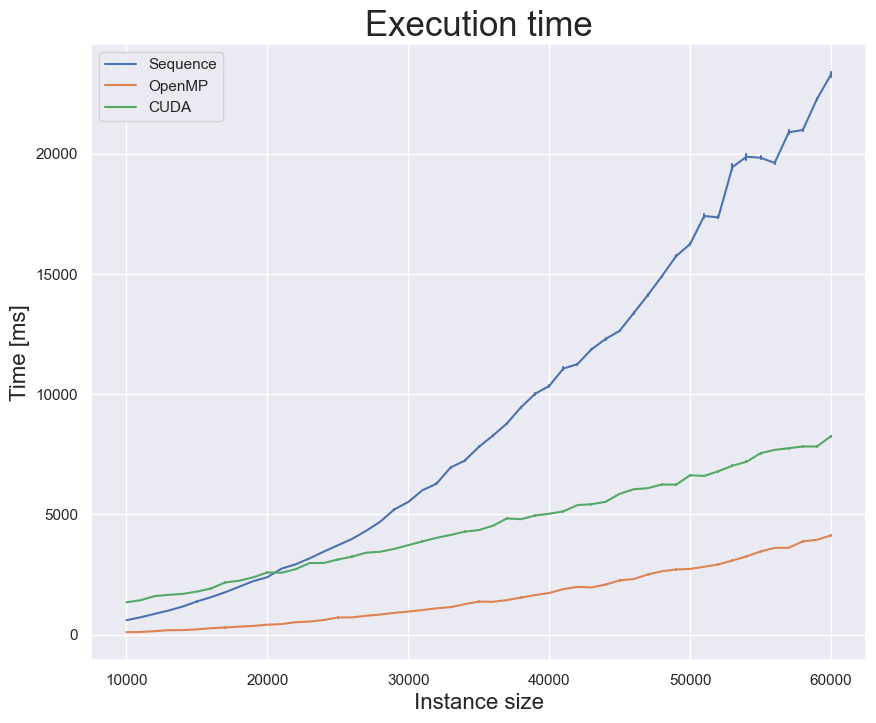

In [4]:
plt.figure(figsize=(10, 8))
sns.set()
sns.lineplot(data=df.to_pandas(), x="size", y="time_seq", errorbar=('ci', 95), err_style='bars', label='Sequence')
sns.lineplot(data=df.to_pandas(), x="size", y="time_openmp", errorbar=('ci', 95), err_style='bars', label='OpenMP')
sns.lineplot(data=df.to_pandas(), x="size", y="time_cuda", errorbar=('ci', 95), err_style='bars', label='CUDA')
plt.legend()
plt.title("Execution time", fontsize=25)
plt.ylabel("Time [ms]", fontsize=16)
plt.xlabel("Instance size", fontsize=16)
plt.savefig('plot.png')
plt.show()

## Speed up

In [6]:
q = (
    df_group.lazy()
    .with_columns(
        (pl.col('seq_mean') / pl.col('openmp_mean')).alias('openmp_speedup'),
        (pl.col('seq_mean') / pl.col('cuda_mean')).alias('cuda_speedup')
    )
    .select(
        pl.col('size'),
        pl.col('openmp_speedup'),
        pl.col('cuda_speedup')
    )
)

df_speed = q.collect()
print(df_speed.head())

shape: (5, 3)
┌───────┬────────────────┬──────────────┐
│ size  ┆ openmp_speedup ┆ cuda_speedup │
│ ---   ┆ ---            ┆ ---          │
│ i64   ┆ f64            ┆ f64          │
╞═══════╪════════════════╪══════════════╡
│ 10000 ┆ 5.899647       ┆ 0.447002     │
│ 11000 ┆ 6.43819        ┆ 0.504526     │
│ 12000 ┆ 5.919481       ┆ 0.53998      │
│ 13000 ┆ 5.428502       ┆ 0.607483     │
│ 14000 ┆ 6.130845       ┆ 0.689906     │
└───────┴────────────────┴──────────────┘


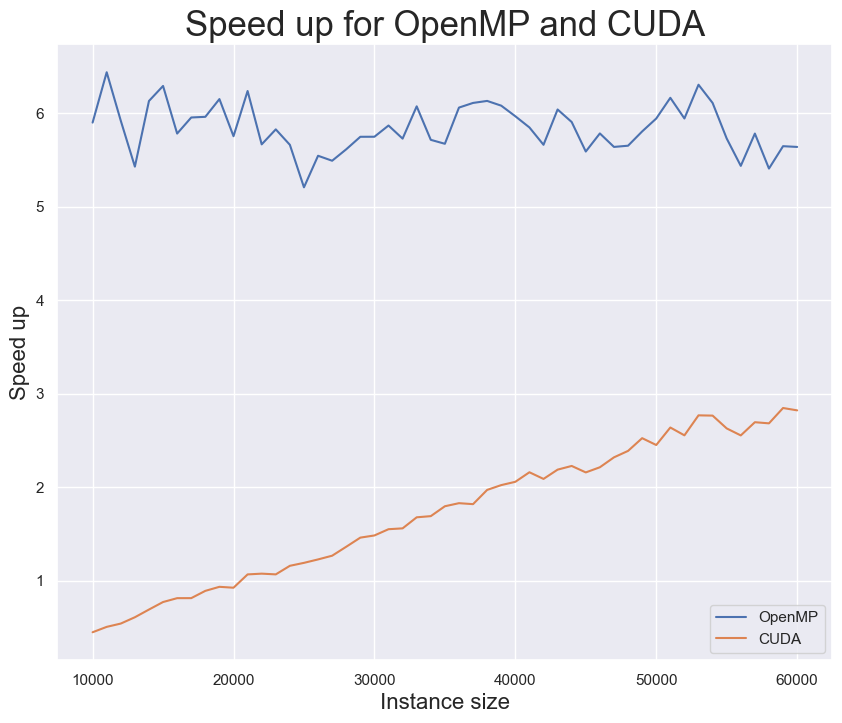

In [8]:
plt.figure(figsize=(10, 8))
sns.set()
sns.lineplot(data=df_speed.to_pandas(), x="size", y="openmp_speedup", label='OpenMP')
sns.lineplot(data=df_speed.to_pandas(), x="size", y="cuda_speedup", label='CUDA')
plt.legend()
plt.title("Speed up for OpenMP and CUDA", fontsize=25)
plt.ylabel("Speed up", fontsize=16)
plt.xlabel("Instance size", fontsize=16)
plt.savefig('plot_speedup.png')
plt.show()